## Project Motivation

The goal of this project is to use pipelines to run one model at a time in order to compare different models and their performances.

## Libraries

In [29]:
!pip install xgboost -q

In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA, KernelPCA
from xgboost import XGBRegressor

## Data

I am using California Housing Data that contains property information of specific regions in the state.

In [6]:
path = "housing.csv"

def load(path, info = True):
    
    import pandas as pd
    import io
    
    if len(path.split(".csv")) > 1:
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        read = pd.read_excel(path)
    
    if info:
        if len(read) > 0:
            print("# Data imported!")
            print("# ------------------------------------", "\n")
        
            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
    
            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False, 
                                                            "No missing value!", "Data includes missing value!"), "\n")
            
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)
          
        else:
            print("# Data did not import!")
    
    return read
    
ab = load(path, info = True)
ab.head()

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 20640 Column: 10 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 1 
 ['ocean_proximity'] 

Float Variables: 
 # of Variables: 9 
 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  Data includes missing value! 

# MEMORY USAGE ---------------------- 
 1.6+ MB


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [7]:
#Descriptive statistics for numerical variables
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [9]:
# Check the unique values of the variable Ocean Proximity
df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

## Data Visualizations

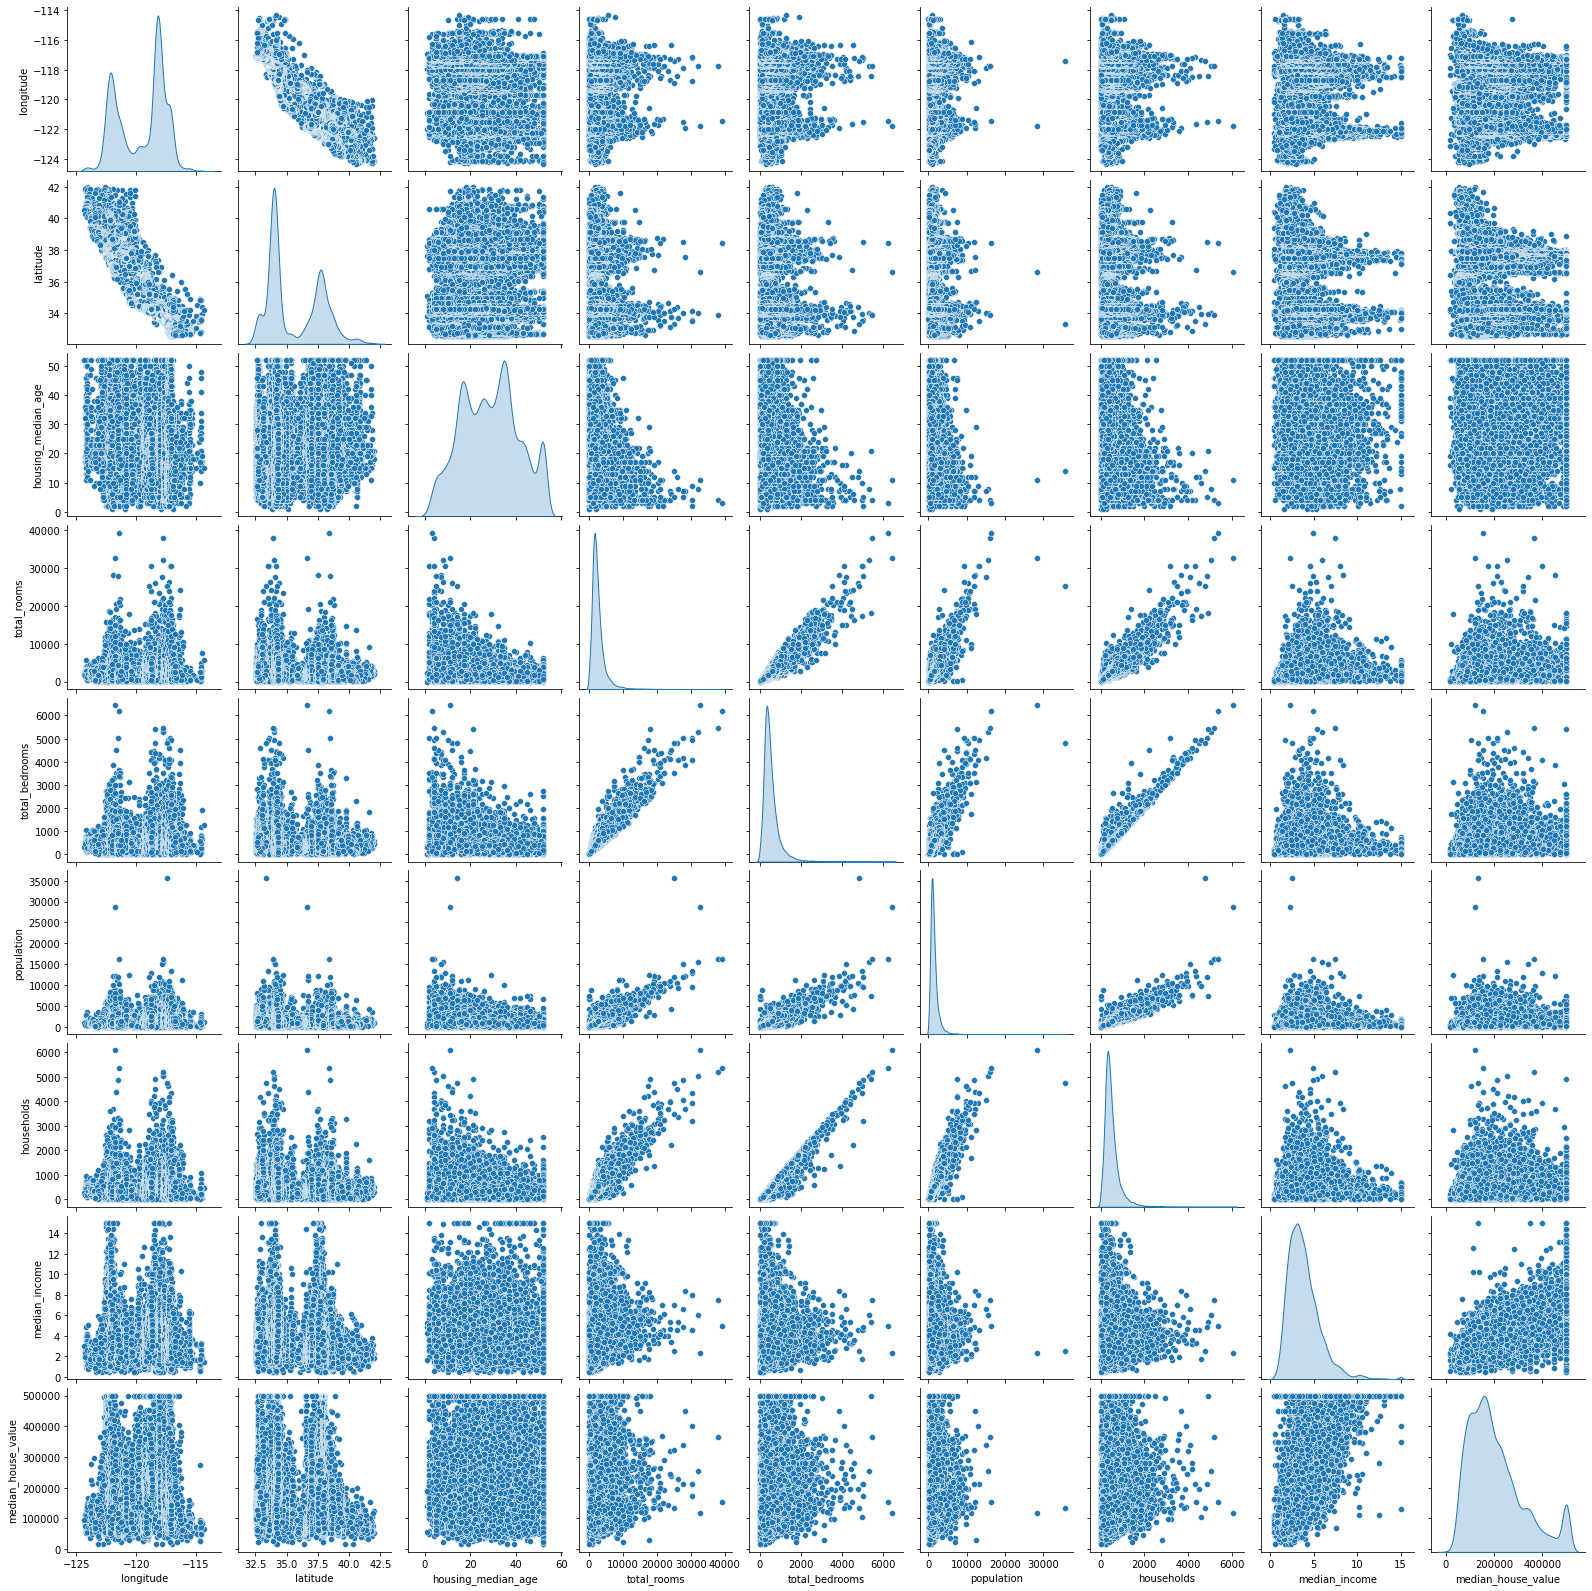

In [30]:
#Pairplot for all data relationships
sns.pairplot(df, diag_kind='kde')

- Longitude and Latitude are related to each other.

- With increase in housing_median_age, the total number of rooms and total number of bedrooms decreases

- The total number of bedrooms is positively correlated with the total number of rooms and number of households

In [12]:
#Initializing the Iterative Imputer with LinearRegression as the estimator
it=IterativeImputer(estimator=LinearRegression())

# column ocean_proximity does not add any significant value to the target median_house_value hence we will drop this column
demo=df.drop('ocean_proximity',1)


#fitting the data and transforming to fill the null values
data=pd.DataFrame(it.fit_transform(demo))

data.columns=demo.columns

data.head()

/var/folders/cp/nw1xyfm52j145dt98x6zq7pw0000gn/T/ipykernel_53717/2042847289.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  demo=df.drop('ocean_proximity',1)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  
0       322.0       126.0         8.3252            452600.0  
1      2401.0      1138.0         8.3014            358500.0  
2       496.0       177.0         7.2574            352100.0  
3       558.0       219.0         5.6431            341300.0  
4       565.0       259.0         3.8462            342200.0

In [13]:
data.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20640.000000  20640.000000  20640.000000   20640.000000   
mean       537.909697   1425.476744    499.539680       3.870671   
std        421.140262   1132.462122    382.329753       1.899822   
min       -112.323177      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [33]:
# no missing value in total_bedrooms after IterativeImputer
# IterativeImputer is useful in this case since the columns are highly correlated with each other
data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

<AxesSubplot:>

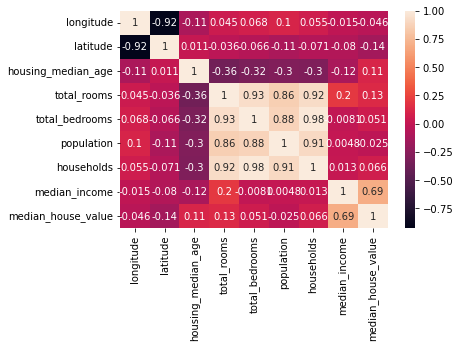

In [14]:
#Checking the strength of relationships with heatmap
sns.heatmap(data.corr(), annot=True)

In [34]:
#Creating test and train datasets

X= data.drop('median_house_value',1)
y=data['median_house_value']

X_train, X_test, y_train, y_test=  train_test_split(X, y, test_size=.33, random_state=0 )

/var/folders/cp/nw1xyfm52j145dt98x6zq7pw0000gn/T/ipykernel_53717/1851843087.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X= data.drop('median_house_value',1)


## Models

### Linear Regression Model

In [22]:
pipe= Pipeline([('pt',PowerTransformer()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
print('Testing Accuracy', pipe.score(X_test, y_test))
print('Training Accuracy', pipe.score(X_train, y_train))

Testing Accuracy -18.64688930086942
Training Accuracy 0.5606287801956039


### XGBoostRegressor

In [23]:
pipe= Pipeline([('pt',PowerTransformer()), ('lr', XGBRegressor(n_estimators=200))])
pipe.fit(X_train, y_train)
print('Testing Accuracy', pipe.score(X_test, y_test))
print('Training Accuracy', pipe.score(X_train, y_train))

Testing Accuracy 0.8218645717219681
Training Accuracy 0.9703307822138811


### PCA followed by a XGBoostRegressor

In [24]:
pipe= Pipeline([('pt',PowerTransformer()),   ('pca', PCA(n_components=4))    , ('lr', XGBRegressor(n_estimators=100))])
pipe.fit(X_train, y_train)
print('Testing Accuracy', pipe.score(X_test, y_test))
print('Training Accuracy', pipe.score(X_train, y_train))

Testing Accuracy 0.5544684015579788
Training Accuracy 0.7913579058332054


### KernelPCA vs PCA followed by XGBoostRegressor

In [25]:
pipe= Pipeline([('pt',PowerTransformer()),   ('pca', KernelPCA())    , ('lr', XGBRegressor(n_estimators=200))])
pipe.fit(X_train, y_train)
print('Testing Accuracy', pipe.score(X_test, y_test))
print('Training Accuracy', pipe.score(X_train, y_train))

Testing Accuracy 0.6794713778125043
Training Accuracy 0.9429310960570013


## XGBoostRegressor with Increased Estimators 

In [36]:
pipe= Pipeline([('pt',PowerTransformer()),   ('pa', KernelPCA())    , ('lr', XGBRegressor(n_estimators=500))])
pipe.fit(X_train, y_train)
print('Testing Accuracy', pipe.score(X_test, y_test))
print('Training Accuracy', pipe.score(X_train, y_train))

Testing Accuracy 0.6680350534189814
Training Accuracy 0.9907873579784919
